In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq

In [4]:
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
print(llm.invoke("What is the capital of France?").content)

<think>
Okay, so I need to figure out the capital of France. Hmm, I think I've heard this before, but I'm not entirely sure. Let me try to remember. I know that France is a country in Europe, and I believe its capital is a pretty famous city. Maybe Paris? That sounds familiar. I've heard of the Eiffel Tower, which is in Paris, right? So, if Paris is the capital, that makes sense because a lot of countries have their capitals associated with well-known landmarks.

Wait, but I'm not 100% certain. Could there be another city that's the capital? I don't think so. I remember learning that London is the capital of England, Berlin is the capital of Germany, and Paris for France. Yeah, that seems to line up. I don't think it's Lyon or Marseille because those are other cities in France but not the capital.

I guess another way to confirm would be to think about government buildings. The capital usually has the main government offices and the president's residence. I think the French president l

In [6]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

C:\Users\MILAN\AppData\Local\Temp\ipykernel_35252\156554669.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


In [7]:
search_tool.invoke("What is the capital of France?")

[{'title': 'Facts About France | Map, Population & Capital - Study.com',
  'url': 'https://study.com/academy/lesson/facts-about-france-location-population-history.html',
  'content': "France is a large European country. The capital of France is Paris, a well-known city. France is very culturally influential. As an example of that cultural influence, the French language is spoken by millions of people outside of France.\n\nThe country's official name is the French Republic; it is a democratic country with a republican form of government. The following is the flag of France:\n\nThe flag of France dates back to the French Revolution\n\nImage 4: Blue, white, and red tricolor [...] France has one of the highest life expectancies in the world, demonstrating its wealth. It does, however, have an average fertility rate and a below-average birth rate.\n\n### Capital of France\n\nParis is the capital of France and one of the most well-known cities in the world. It is the home to many world-famou

In [8]:
from langchain_experimental.utilities import PythonREPL

In [9]:
repl=PythonREPL()

In [10]:
my_code = """
x=10
y=x+10
print(y)
"""

In [11]:
repl.run(my_code)

Python REPL can execute arbitrary code. Use with caution.


'20\n'

In [12]:
from typing import Annotated

In [13]:
from langchain_core.tools import tool

In [45]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

## WE HAVE TWO SUB AGENT
RESEARCHER- internet

CODER- executing the code

In [46]:
members=["researcher","coder"]

In [47]:
options = members+["FINISH"]

In [48]:
options

['researcher', 'coder', 'FINISH']

In [49]:
from typing import Literal

In [50]:
from typing_extensions import TypedDict

## it is simply going to return the next candidate(next_agent)
this next is containig the next candidate name

In [51]:
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

In [53]:
from langgraph.graph import MessagesState,StateGraph,START, END

In [54]:
class State(MessagesState):
    next:str

In [ ]:
### this is how the state will look like
## all messages will be stored in the messages list
class State(MessagesState):
    next:str
state={"messages": ["hi","what is sqt of 42", "what is captial of india"], "next": "research_agent"}

In [55]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [59]:
from langgraph.types import Command

In [60]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my response {'next': 'researcher'}
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
    
    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}
    
    return Command(goto=goto, update={"next":goto})

In [61]:
from langgraph.prebuilt import create_react_agent

In [62]:
from langchain_core.messages import AIMessage, HumanMessage

In [67]:
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [68]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
    

## this is my orchestration flow with langgraph

In [64]:
graph=StateGraph(State)

In [65]:
graph.add_node("supervisor", supervisor_agent)

In [69]:
graph.add_node("researcher", research_agent)

In [70]:
graph.add_node("coder", coder_agent)

In [71]:
graph.add_edge(START, "supervisor")

In [72]:
app=graph.compile()

In [73]:
from IPython.display import display,Image

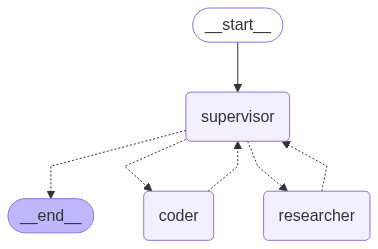

In [74]:
display(Image(app.get_graph().draw_mermaid_png()))

In [81]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:e149b6dc-d7d5-1045-be3f-df0eba1798c9',), {'agent': {'messages': [AIMessage(content='The square root of 42 is approximately 6.4807. In its exact form, it is expressed as √42.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 473, 'prompt_tokens': 179, 'total_tokens': 652, 'completion_time': 1.8178442160000001, 'prompt_time': 0.011223221, 'queue_time': 0.216005178, 'total_time': 1.829067437}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--12c866cc-7b13-48c1-a42c-1c17f773438a-0', usage_metadata={'input_tokens': 179, 'output_tokens': 473, 'total_tokens': 652})]}})
**********BELOW IS MY STATE***************
((), {'researcher': {'messages': [HumanMessage(content='The square root of 42 is approximately 6.4807. In its exa

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ''}}